In [15]:
# this notebook will take ML approach to predict the futuristic momentum of the stock price

In [16]:
# Step 1: Load and Concatenate All CSV Files
import os
import pandas as pd

# Function to load all CSV files from a directory
def load_data_from_folder(folder_path):
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    data_frames = []

    for file in all_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        data_frames.append(df)

    # Concatenate all dataframes into one
    return pd.concat(data_frames, ignore_index=True)

# Load data from both folders
data_august = load_data_from_folder('data/ETH_2023-08')
data_september = load_data_from_folder('data/ETH_2023-09')

# Combine both datasets
df = pd.concat([data_august, data_september], ignore_index=True)

# Show the first few rows of the combined data
df.head()


,open_time,open,high,low,close,volume,close_time,count
0,1691280000000,1836.48,1836.48,1836.47,1836.48,0.3538,1691280000999,10
1,1691280001000,1836.48,1836.48,1836.47,1836.47,0.4028,1691280001999,5
2,1691280002000,1836.48,1836.48,1836.48,1836.48,0.0854,1691280002999,1
3,1691280003000,1836.48,1836.48,1836.47,1836.47,0.1518,1691280003999,3
4,1691280004000,1836.48,1836.48,1836.48,1836.48,0.0109,1691280004999,1


In [17]:
# Step 2: Data Preprocessing and Feature Engineering
# Now that all the data is loaded, we can proceed with creating features like moving averages, returns, and volatility.

# Create new features for feature engineering
# df['price_return'] = df['close'].pct_change()  # Percentage change in price
df['volatility'] = df['close'].rolling(window=60).std()  # Volatility over the last 60 seconds
# df['volume_return'] = df['volume'].pct_change()  # Percentage change in volume
df['ma_10'] = df['close'].rolling(window=10).mean()  # 10-second moving average
df['ma_30'] = df['close'].rolling(window=30).mean()  # 30-second moving average

# Drop rows with NaN values created by rolling operations
df.dropna(inplace=True)

# Show the data after feature engineering
df.head()


,open_time,open,high,low,close,volume,close_time,count,volatility,ma_10,ma_30
59,1691280059000,1836.30,1836.30,1836.29,1836.30,1.1798,1691280059999,32,0.091856,1836.291,1836.294000
60,1691280060000,1836.30,1836.30,1836.29,1836.30,0.2764,1691280060999,9,0.091435,1836.292,1836.294000
61,1691280061000,1836.30,1836.30,1836.29,1836.29,0.9097,1691280061999,2,0.091245,1836.292,1836.293667
62,1691280062000,1836.29,1836.29,1836.29,1836.29,0.0000,1691280062999,0,0.090759,1836.292,1836.293667
63,1691280063000,1836.29,1836.29,1836.29,1836.29,0.0242,1691280063999,1,0.090360,1836.292,1836.293667


In [24]:
# Step 3: Labeling Future Momentum
# Next, we’ll label future momentum based on the future price movement.
import numpy as np

# Define a momentum window (e.g., look 30 seconds into the future)
momentum_window = 10

# Create a target column for future momentum
df['future_return'] = df['close'].shift(-momentum_window).pct_change(periods=momentum_window)

# Label the data based on the future momentum
df['target'] = np.where(df['future_return'] > 0, 1, 0)

# Drop rows with NaN values in the target
df.dropna(inplace=True)

# Show the labeled data
df[['close', 'future_return', 'target']].head(15)


/var/folders/1k/xrnsys5s7b39s_ylmkgng4fw0000gn/T/ipykernel_61387/3277456857.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['future_return'] = df['close'].shift(-momentum_window).pct_change(periods=momentum_window)


,close,future_return,target
109,1836.14,-0.000005,0
110,1836.14,-0.000005,0
111,1836.14,0.000000,0
112,1836.14,0.000000,0
113,1836.14,0.000000,0
114,1836.14,0.000000,0
115,1836.13,0.000005,1
116,1836.14,0.000000,0
117,1836.14,0.000000,0
118,1836.13,0.000005,1


In [25]:
# Step 4: Train/Test Split
# Now we’ll split the dataset into training and testing sets. We’ll use an 80/20 split.

from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df[['close', 'volatility', 'ma_10', 'ma_30']]  # Features: price, volatility, moving averages
y = df['target']  # Target: 1 if the price goes up, 0 otherwise


# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check the shape of the training and testing sets
X_train.shape, X_test.shape


((4216232, 4), (1054059, 4))

In [26]:
# Step 5: Model Training
# We’ll train a machine learning model, such as a Random Forest classifier, on the training data.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Display classification report to evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.66      0.74      0.70    679799
           1       0.40      0.31      0.35    374260

    accuracy                           0.59   1054059
   macro avg       0.53      0.53      0.52   1054059
weighted avg       0.57      0.59      0.57   1054059



In [27]:
# Step 6: Model Evaluation
# Evaluate the accuracy and other metrics to see how well the model performed on the test data.

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 58.70%


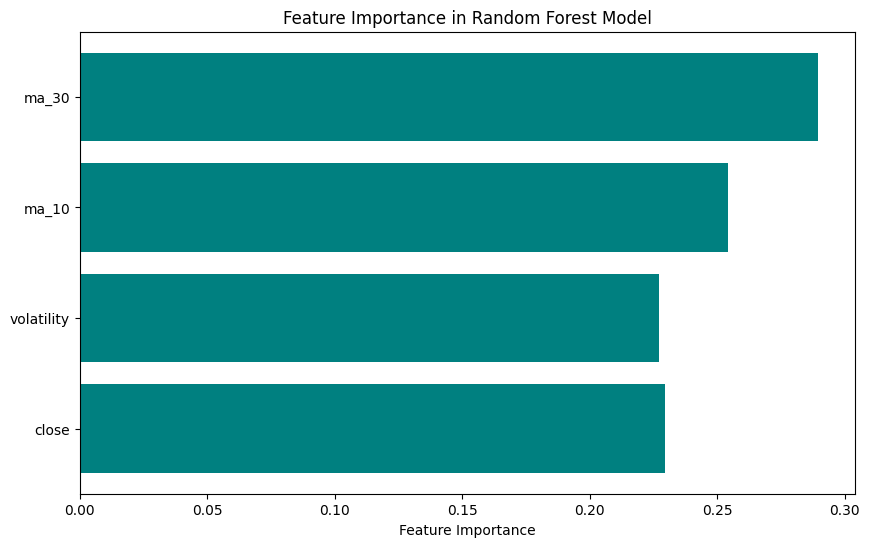

In [28]:
# Step 7: Feature Importance 
# we'll look at the importance of different features in the Random Forest model.

import matplotlib.pyplot as plt

# Get feature importances from the model
importances = model.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='teal')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()


In [29]:
# save the model
import joblib

# Save the model as a pickle file
joblib.dump(model, 'model.pkl')
print("Model saved as model.pkl")

Model saved as model.pkl
